In [1]:
import numpy as np
import pandas as pd
import pickle
import time
from loadData_adult import load_data
from normalizeData import normalize_data
from projectData import project_data
from fairPCA import fair_pca
from lloyd import lloyd
from giveRandCenters import give_rand_centers
from findClustering import find_clustering
from compCost import comp_cost
from collections import defaultdict
import scipy.io
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from collections import defaultdict
from scipy.optimize import linear_sum_assignment


In [27]:
def load_data(k, dataset):
    df = pd.read_csv(f'{dataset}_violating_labeled_{k}.csv')
    data = scipy.io.loadmat(f'results_fair_clustering_{dataset}_{k}.mat')
    unfair_data = scipy.io.loadmat(f'unfair_clustering_{dataset}_{k}.mat')
    idx = k - 1

    unfair_clustering = data['clusteringN'][idx][0] - 1
    fair_clustering_females = data['clusteringNF'][idx][0][0][0].flatten()
    fair_clustering_males = data['clusteringNF'][idx][0][0][1].flatten()

    # Adjust group detection based on dataset
    if dataset == "adult" or dataset == "student":
        female_indices = df[df['sex'] == 0].index.values
        male_indices = df[df['sex'] == 1].index.values
    elif dataset == "credit":
        female_indices = df[df['MARRIAGE'] == 1].index.values
        male_indices = df[df['MARRIAGE'] == 2].index.values
    elif dataset == "bank":
        female_indices = df[df['marital'] == 0].index.values
        male_indices = df[df['marital'] == 1].index.values
    else:
        raise ValueError("Unknown dataset")

    fair_clustering_full = np.full(df.shape[0], -1, dtype=int)
    fair_clustering_full[female_indices] = fair_clustering_females
    fair_clustering_full[male_indices] = fair_clustering_males

    return df, unfair_clustering.flatten(), fair_clustering_full, female_indices, male_indices


def align_clusters(ref_labels, pred_labels):
    cm = confusion_matrix(ref_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_map = {col: row for row, col in zip(row_ind, col_ind)}
    aligned_pred = np.array([label_map[label] for label in pred_labels])
    return aligned_pred, label_map


def count_misaligned(unfair, fair_aligned):
    return np.sum(unfair != fair_aligned)


def compute_nmi(unfair, fair):
    return normalized_mutual_info_score(unfair, fair)


def process_k(k, dataset):
    df, unfair, fair, female_indices, male_indices = load_data(k, dataset)
    fair_aligned, _ = align_clusters(unfair, fair)
    misaligned = count_misaligned(unfair, fair_aligned)
    nmi = compute_nmi(unfair, fair)

    nmi_female = compute_nmi(unfair[female_indices], fair[female_indices])
    nmi_male = compute_nmi(unfair[male_indices], fair[male_indices])

    return {
        "k": k,
        "nmi": nmi,
        "nmi_female": nmi_female,
        "nmi_male": nmi_male,
        "misaligned": misaligned,
        "unfair": unfair,
        "fair": fair,
        "aligned_fair": fair_aligned,
        "df": df
    }


def run_all_ks(k_range, dataset):
    results = []
    for k in k_range:
        try:
            print(f"Processing {dataset}, k={k}...")
            results.append(process_k(k, dataset))
        except Exception as e:
            print(f"Failed to process k={k} for {dataset}: {e}")
    return results

def save_nmi_results(results, dataset):
    df = pd.DataFrame(results)
    os.makedirs("results_nmi_fair_lloyd", exist_ok=True)
    df.to_csv(f"results_nmi_fair_lloyd/nmi_results_{dataset}_fair_lloyd.csv", index=False)
    print(f"Saved NMI results to results_nmi/nmi_results_{dataset}.csv")
 
if __name__ == '__main__':
    datasets = ["adult", "bank", "student", "credit"]
    k_range = range(4, 11)

    for dataset in datasets:
        results = run_all_ks(k_range, dataset)
        save_nmi_results(results, dataset)


Processing adult, k=4...
Processing adult, k=5...
Processing adult, k=6...
Processing adult, k=7...
Processing adult, k=8...
Processing adult, k=9...
Processing adult, k=10...
Saved NMI results to results_nmi/nmi_results_adult.csv
Processing bank, k=4...
Processing bank, k=5...
Processing bank, k=6...
Processing bank, k=7...
Processing bank, k=8...
Processing bank, k=9...
Processing bank, k=10...
Saved NMI results to results_nmi/nmi_results_bank.csv
Processing student, k=4...
Processing student, k=5...
Processing student, k=6...
Processing student, k=7...
Processing student, k=8...
Processing student, k=9...
Processing student, k=10...
Saved NMI results to results_nmi/nmi_results_student.csv
Processing credit, k=4...
Processing credit, k=5...
Processing credit, k=6...
Processing credit, k=7...
Processing credit, k=8...
Processing credit, k=9...
Processing credit, k=10...
Saved NMI results to results_nmi/nmi_results_credit.csv


In [29]:
def plot_nmi_comparison(datasets, k_range, dir1, dir2):
    for dataset in datasets:
        file1 = os.path.join(dir1, f"nmi_results_{dataset}.csv")
        file2 = os.path.join(dir2, f"nmi_results_{dataset}_fair_lloyd.csv")

        if not os.path.exists(file1) or not os.path.exists(file2):
            print(f"Missing file for {dataset}, skipping...")
            continue

        df1 = pd.read_csv(file1)
        df2 = pd.read_csv(file2)

        plt.figure(figsize=(8, 6))

        label_f0 = 'social (F)'
        label_f1 = 'social (M)'
        label_f2 = 'balance (F)'
        label_f3 = 'balance (M)'
        if dataset in ['bank', 'credit']:
            label_f0 = 'social (M)'
            label_f1 = 'social (S)'
            label_f2 = 'balance (M)'
            label_f3 = 'balance (S)'

        plt.plot(df1['k'], 1 - df2['nmi_female'], color='purple', marker='o', label=label_f0, linewidth=3)
        plt.plot(df1['k'], 1 - df2['nmi_male'],   color='green', marker='o', label=label_f1, linewidth=3)
        plt.plot(df2['k'], 1 - df1['nmi_female'], color='orange', marker='o', label=label_f2, linewidth=3)
        plt.plot(df2['k'], 1 - df1['nmi_male'],   color='navy', marker='o', label=label_f3, linewidth=3)

        # Axis labels
        plt.ylabel("NMI cost", labelpad=10,fontsize=20)
        plt.xlabel(r"$k$", fontsize=20)
        
        
        # Title
        
        # Tick sizes
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        
        # Legend
        plt.legend(fontsize=16)
        plt.tight_layout()
        plt.savefig(f"nmi_group_comparison_{dataset}.pdf")
        plt.show()

def plot_misalignment_from_file(dataset, k_range, dir_path):
    # Construct file path
    file_path = os.path.join(dir_path, f"mis_results_{dataset}_fair_lloyd.csv")

    if not os.path.exists(file_path):
        print(f"Missing file for {dataset}, skipping...")
        return

    # Read CSV
    df = pd.read_csv(file_path)
    
    # Filter for k values in k_range and sort
    df = df[df['k'].isin(k_range)].sort_values(by='k')

    # Extract values
    k_values = df['k'].tolist()
    mis_fl_female = df['mis_fl_female'].tolist()
    mis_fl_male = df['mis_fl_male'].tolist()
    mis_b_female = df['mis_b_female'].tolist()
    mis_b_male = df['mis_b_male'].tolist()

    # Assign legend labels based on dataset
    label_f0 = 'social (F)'
    label_f1 = 'social (M)'
    label_f2 = 'balance (F)'
    label_f3 = 'balance (M)'
    if dataset in ['bank', 'credit']:
        label_f0 = 'social (M)'
        label_f1 = 'social (S)'
        label_f2 = 'balance (M)'
        label_f3 = 'balance (S)'

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(k_values, mis_fl_female, color='purple', marker='o', label=label_f0, linewidth=2)
    plt.plot(k_values, mis_fl_male, color='green', marker='o', label=label_f1, linewidth=3)
    plt.plot(k_values, mis_b_female, color='orange', marker='o', label=label_f2, linewidth=3)
    plt.plot(k_values, mis_b_male, color='navy', marker='o', label=label_f3, linewidth=2)

    plt.xlabel(r"$k$", fontsize=20)
    plt.ylabel("Misaligned cost", labelpad=10, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16)
    plt.tight_layout()

    # Save and show
    plt.savefig(f"mis_balance_fl_{dataset}.pdf")
    plt.show()

def counterfactual_cost(dataset, k_range, dir_path):
    # Construct file path
    file_path = os.path.join(dir_path, f"cost_results_{dataset}_fair_lloyd.csv")

    if not os.path.exists(file_path):
        print(f"Missing file for {dataset}, skipping...")
        return

    # Read CSV
    df = pd.read_csv(file_path)

    # Filter for k values in k_range and sort
    df = df[df['k'].isin(k_range)].sort_values(by='k')

    # Extract values
    k_values = df['k'].tolist()
    dist_fl_female = df['dist_fl_female'].tolist()
    dist_fl_male = df['dist_fl_male'].tolist()
    dist_b_female = df['dist_b_female'].tolist()
    dist_b_male = df['dist_b_male'].tolist()

    # Assign labels depending on dataset
    label_f0 = 'social (F)'
    label_f1 = 'social (M)'
    label_f2 = 'balance (F)'
    label_f3 = 'balance (M)'
    if dataset in ['bank', 'credit']:
        label_f0 = 'social (M)'
        label_f1 = 'social (S)'
        label_f2 = 'balance (M)'
        label_f3 = 'balance (S)'

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, dist_fl_female, color='purple', marker='o', label=label_f0, linewidth=2)
    plt.plot(k_values, dist_fl_male, color='green', marker='o', label=label_f1, linewidth=3)
    plt.plot(k_values, dist_b_female, color='orange', marker='o', label=label_f2, linewidth=3)
    plt.plot(k_values, dist_b_male, color='navy', marker='o', label=label_f3, linewidth=2)

    plt.xlabel(r"$k$", fontsize=20)
    plt.ylabel("Counterfactual cost", labelpad=10, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"dist_balance_fl_{dataset}.pdf")
    plt.show()


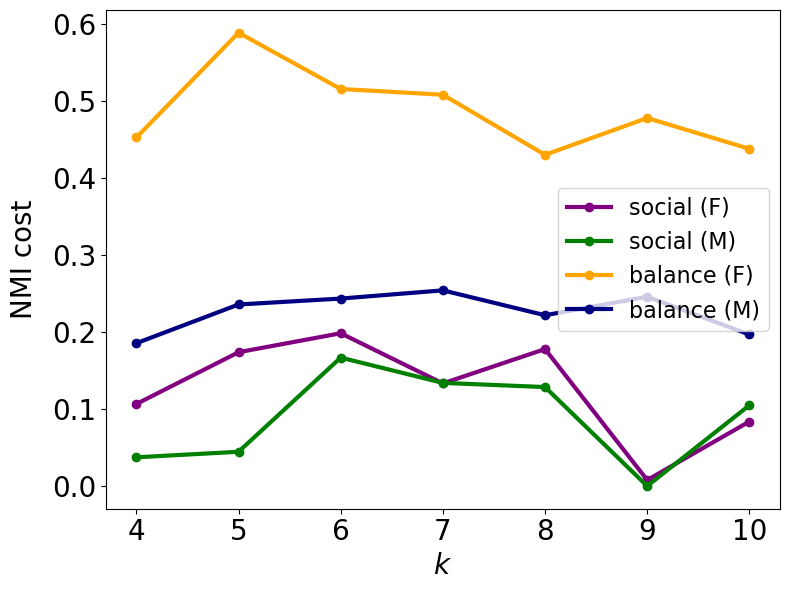

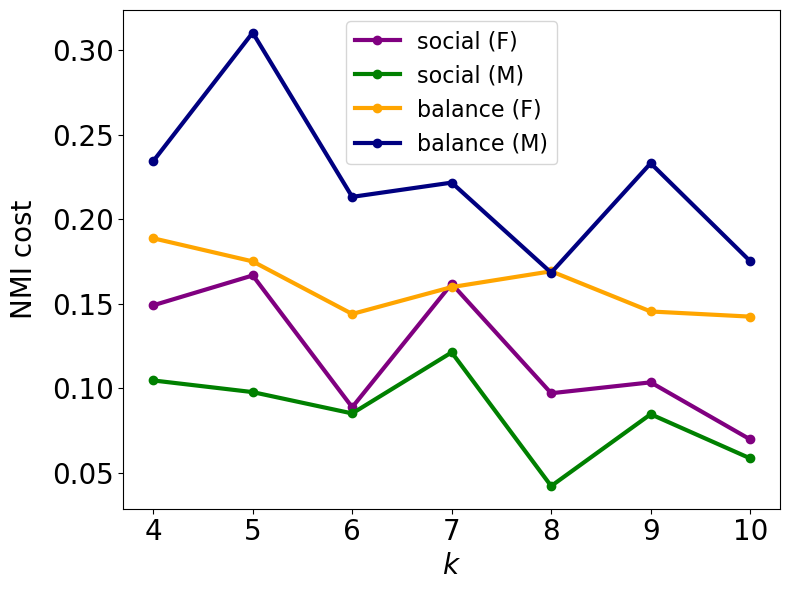

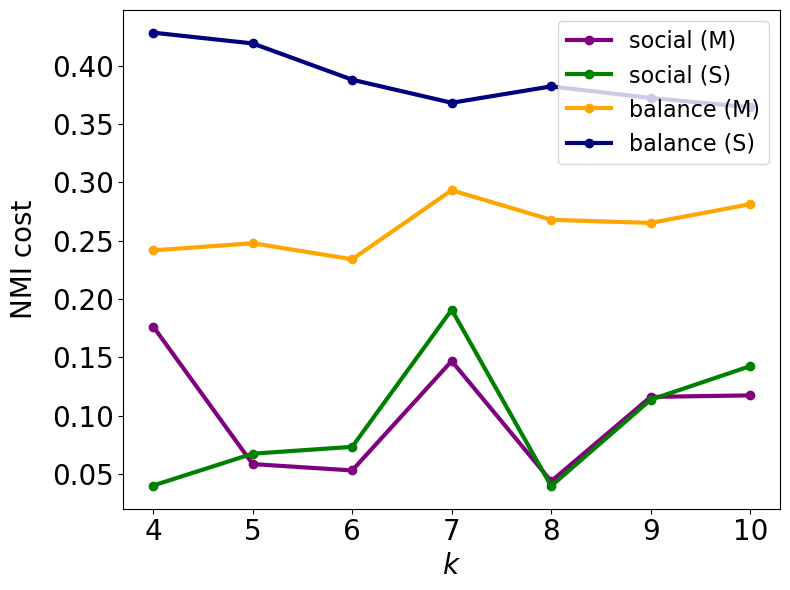

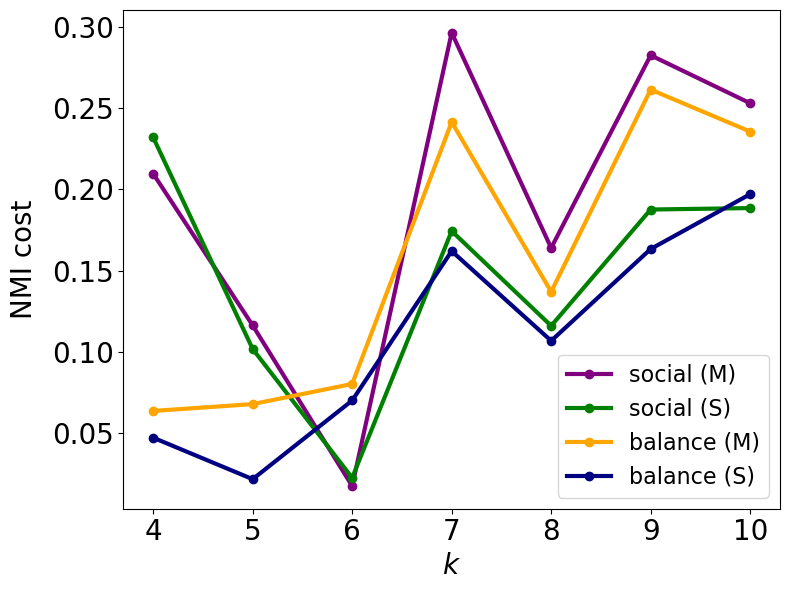

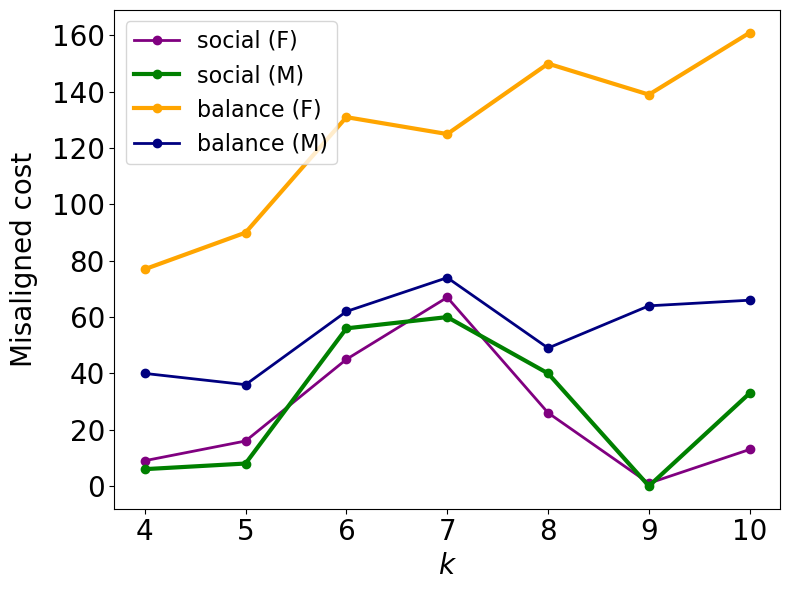

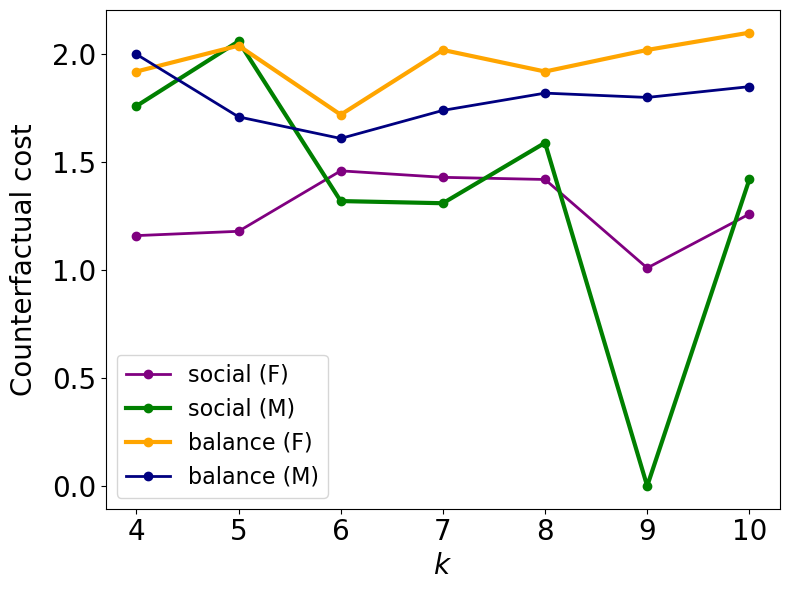

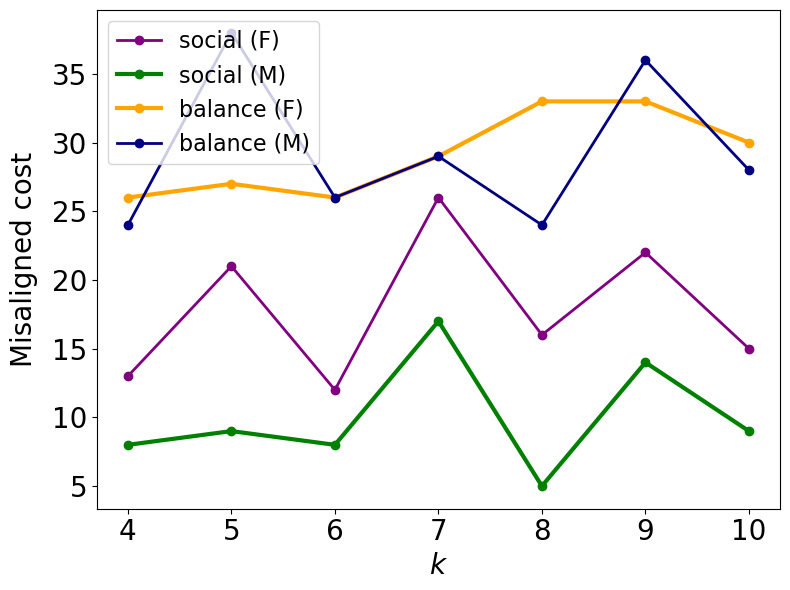

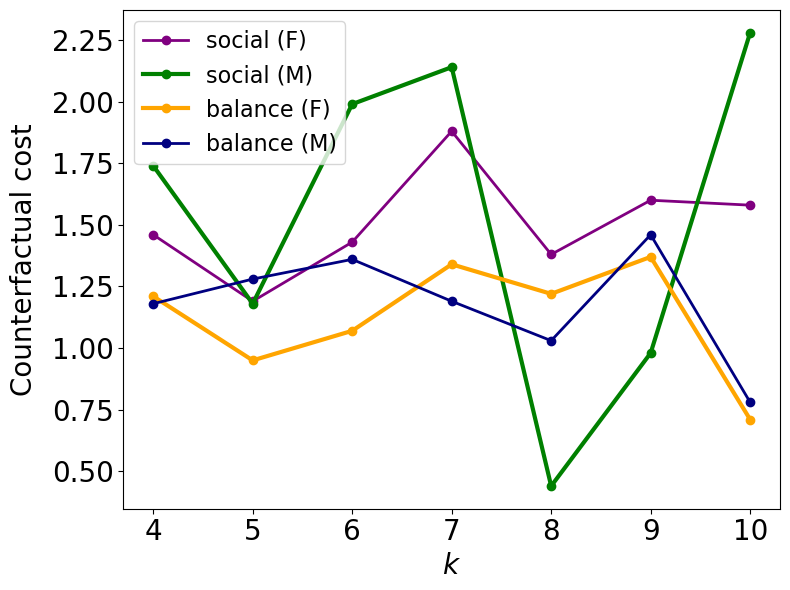

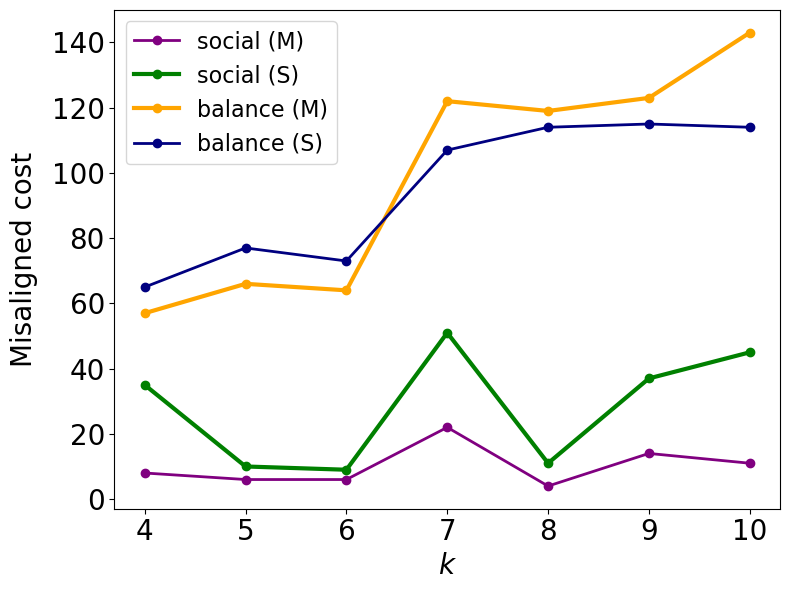

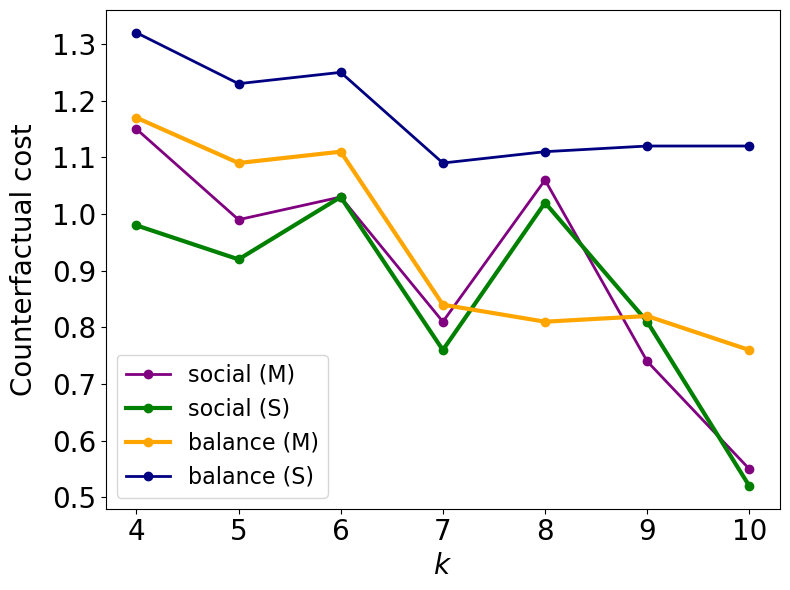

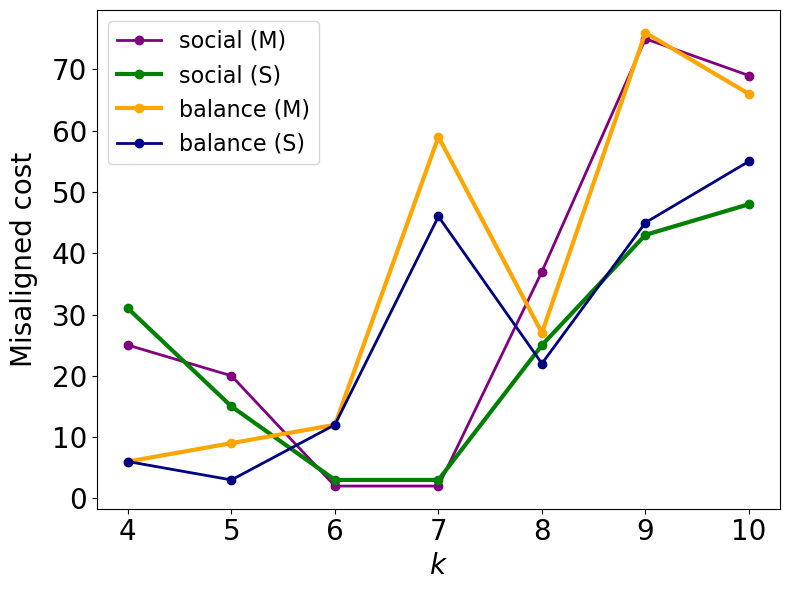

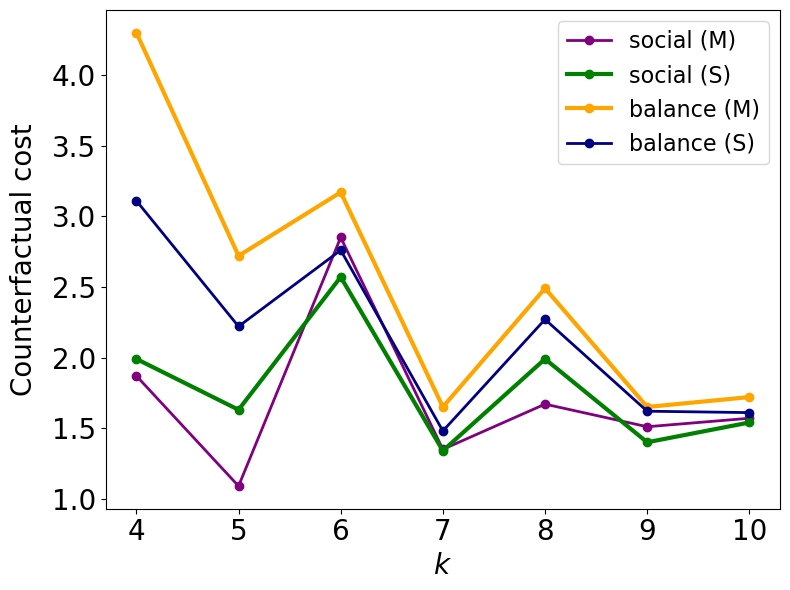

In [31]:
if __name__ == '__main__':
    datasets = ["adult", "student", "bank", "credit"]
    k_range = range(4, 11)
    dir1 = "results_nmi_balance"
    dir2 = "results_nmi_fair_lloyd"
    plot_nmi_comparison(datasets, k_range, dir1, dir2)
    dir_path_mis = "results_mis"
    dir_path_dist ="cfcost"
    for dataset in datasets:
            plot_misalignment_from_file(dataset, k_range, dir_path_mis)
            counterfactual_cost(dataset, k_range, dir_path_dist)
